<a href="https://colab.research.google.com/github/Michel93DM/Deep-Learning---Score-Based-Models/blob/main/WGAN_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time

In [ ]:
SEED=42
random.seed(SEED)
torch.manual_seed(SEED)

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
input_size = 100
z_size = 100

mode_z = 'normal'
# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

#Gradient penalty constant
lambda_gp = 10


# different Learning rate for optimizers
g_lr = 0.0002
d_lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5
ngpu=1

In [ ]:
print(torch.__version__)
print('GPU Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = 'cpu'

print(device)

2.0.0+cu118
GPU Available: True
cuda:0


In [ ]:
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)),])
CIFAR_dataset= torchvision.datasets.CIFAR10(root='../input', train=True,
                                        download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(CIFAR_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

example1, label1 = next(iter(CIFAR_dataset))
print(f'Min: {example1.min() } Max : {example1.max()}')
print(example1.shape)

100%|██████████| 170498071/170498071 [00:03<00:00, 44615452.36it/s]


Extracting ../input/cifar-10-python.tar.gz to ../input
Min: -0.9921568632125854 Max : 0.9764705896377563
torch.Size([3, 64, 64])


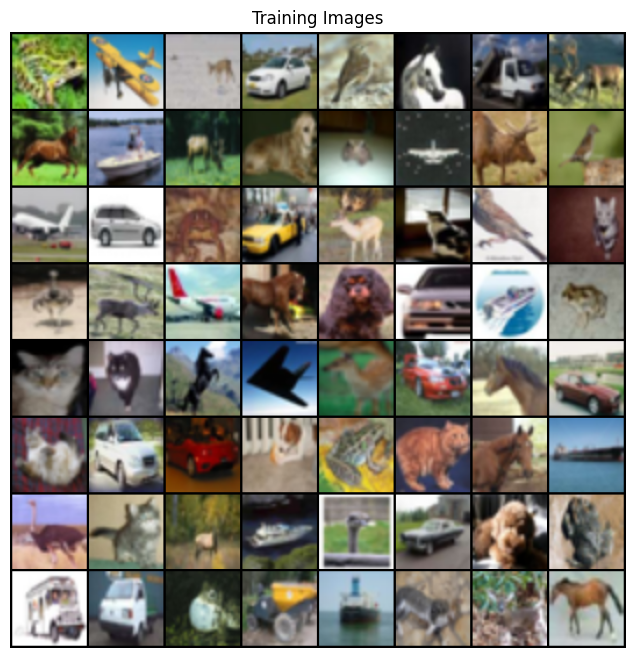

In [ ]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
real_batch = next(iter(dataloader))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], 
                        padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def make_generator_network_wgan(input_size, ngf, nc):
    model = nn.Sequential(
        nn.ConvTranspose2d( input_size, ngf * 8, 4, 1, 0, bias=False),
        nn.InstanceNorm2d(ngf * 8),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(ngf * 4),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(ngf * 2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(ngf),
        nn.LeakyReLU(0.2),
        
        nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
        nn.Tanh()
        
        )
    return model
        

In [ ]:
# Create the generator
gen_model = make_generator_network_wgan(input_size, ngf, nc).to(device)
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (11): LeakyReLU(negative_slope=0.2)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13)

In [ ]:
class DiscriminatorWGAN(nn.Module):
    def __init__(self, ngpu):
        super(DiscriminatorWGAN, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the Discriminator
disc_model = DiscriminatorWGAN(ngpu).to(device)
print(disc_model)

DiscriminatorWGAN(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [ ]:
# Setup Adam optimizers for both G and D
d_optimizer = optim.Adam(disc_model.parameters(), lr=d_lr)
g_optimizer = optim.Adam(gen_model.parameters() , lr=g_lr)

In [ ]:
from torch.autograd import grad as torch_grad

def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)
    
    #calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1,1,1,
                      requires_grad = True, device= device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    
    #calculate propability of interpolated examples
    proba_interpolated = disc_model(interpolated)
    
    #Calculate gradients of propabilities
    gradients = torch_grad(
        outputs = proba_interpolated, inputs = interpolated, 
        grad_outputs= torch.ones(proba_interpolated.size(), device = device),
        create_graph = True, retain_graph=True
                )[0]
    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm -1) **2).mean()

In [ ]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 101MB/s] 


In [ ]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

In [ ]:
def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size,1,1)*2 - 1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size,1 ,1)
  return input_z

In [ ]:
fixed_z= create_noise(batch_size, z_size, mode_z).to(device)
                                                     
def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    fake_display = g_model(input_z).detach().cpu()
    return fake_display

In [ ]:
fixed_z.size()

torch.Size([128, 100, 1, 1])

In [ ]:
def d_train_wgan(x):
    disc_model.zero_grad()
    
    batch_size = x.size(0)
    x= x.to(device)
    
    # Claculate probabilites on real and generated data
    
    d_real = disc_model(x)
    
    input_z = create_noise(batch_size, z_size,mode_z).to(device)
    
    g_output = gen_model(input_z)
    #fretchet_dist=calculate_fretchet(x,g_output,model)
    d_generated = disc_model(g_output)
    
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    
    d_loss.backward()
    
    d_optimizer.step()
    
    return d_loss.data.item()
    #, fretchet_dist

def g_train_wgan(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size,mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    
    g_loss = -d_generated.mean()
    
    #gradient backprop & optimize only G's parametrs
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss.data.item()

In [ ]:
epoch_samples_wgan = []
fretchet_dist_all  = []
torch.manual_seed(1)

critic_iterations = 5

for epoch in range(1, num_epochs +1):
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(dataloader):
        for _ in range (critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))
        #fretchet_dist = d_train_wgan(x)[1]  
    
    input_z = create_noise(batch_size, z_size,mode_z).to(device)
    g_output = gen_model(input_z)
    fretchet_dist=calculate_fretchet(x,g_output,model)
    fretchet_dist_all.append(fretchet_dist) 
        
    print(f'Epoch {epoch:03d} | AVG Loss >>'
          f'D/G {torch.FloatTensor(d_losses).mean():.4f}'
          f'/{torch.FloatTensor(g_losses).mean():.4f}'
          f'FID = {fretchet_dist.mean():.2f}')
    gen_model.eval()
    epoch_samples_wgan.append(vutils.make_grid(create_samples(gen_model, fixed_z), padding=2, normalize=True))


Epoch 001 | AVG Loss >>D/G 0.5073/-0.0190FID = 471.07
Epoch 002 | AVG Loss >>D/G -0.3344/-0.0218FID = 380.98
Epoch 003 | AVG Loss >>D/G -0.3226/-0.0213FID = 319.60
Epoch 004 | AVG Loss >>D/G -0.6451/-0.0251FID = 315.72
Epoch 005 | AVG Loss >>D/G -0.8552/-0.0118FID = 341.40
Epoch 006 | AVG Loss >>D/G -0.8342/-0.0209FID = 380.49
Epoch 007 | AVG Loss >>D/G -0.8526/-0.0188FID = 275.36
Epoch 008 | AVG Loss >>D/G -0.8474/-0.0209FID = 277.49
Epoch 009 | AVG Loss >>D/G -0.8611/-0.0215FID = 255.83
Epoch 010 | AVG Loss >>D/G -0.8479/-0.0248FID = 239.32
Epoch 011 | AVG Loss >>D/G -0.8702/-0.0197FID = 237.04
Epoch 012 | AVG Loss >>D/G -0.8756/-0.0212FID = 246.41
Epoch 013 | AVG Loss >>D/G -0.8814/-0.0182FID = 255.39
Epoch 014 | AVG Loss >>D/G -0.8675/-0.0194FID = 259.39
Epoch 015 | AVG Loss >>D/G -0.8852/-0.0189FID = 251.33
Epoch 016 | AVG Loss >>D/G -0.8454/-0.0255FID = 278.54
Epoch 017 | AVG Loss >>D/G -0.8553/-0.0273FID = 313.29
Epoch 018 | AVG Loss >>D/G -0.8629/-0.0323FID = 287.22
Epoch 019 |

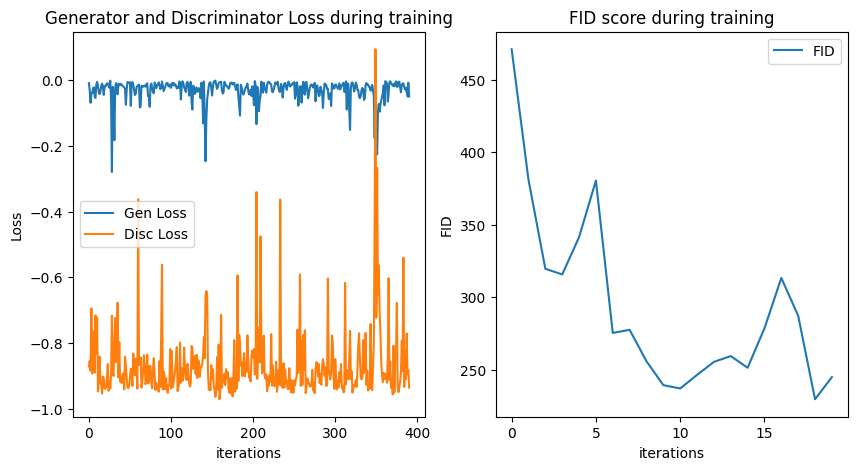

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
#plt.figure(figsize=(10,5))
ax1.title.set_text("Generator and Discriminator Loss during training")
ax2.title.set_text("FID score during training")
ax1.plot(g_losses, label="Gen Loss")
ax1.plot(d_losses, label="Disc Loss")
ax2.plot(fretchet_dist_all, label="FID")
ax1.set(xlabel="iterations", ylabel="Loss")
ax2.set(xlabel="iterations", ylabel="FID")
plt.legend()
ax1.legend()
plt.show()